**Autor**: Victor Teixidó López

In [ ]:
!pip install apafib --upgrade --user --quiet

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor

from sklearn.inspection import permutation_importance

from yellowbrick.regressor import prediction_error

# LA INFLUENCIA DE LA CESTA DE LA COMPRA

Uno de los datos que recolecta la web de la ciutat al día del ayuntamiento de Barcelona es la evolución del precio de los alimentos (verduras, fruta,carne, pescado). Una cosa que nos podemos preguntar es en que otra información puede tener influencia esta evolución y cuál de estos productos es el que tiene más relación. Igual que en otros problemas que usan este conjunto de datos, correlación no significa causalidad, la relación suele corresponden a otras variables no observadas, pero a falta de conocerlas podemos usar las relaciones que aparecen para formular hipótesis.

En este caso nos podemos preguntar si esta evolución de precios tiene relación con la evolución de reservas hoteleras internacionales en Barcelona.

In [ ]:
from apafib import load_BCN_cesta

cesta_data = load_BCN_cesta()
cesta_data.head()

,Carn / Pollastre,Carn / Porcí,Fruites i hortalisses / Ceba,Fruites i hortalisses / Patata,Fruites i hortalisses / Plàtan,Fruites i hortalisses / Poma,Fruites i hortalisses / Taronja,Peix i marisc / Llenguado,Peix i marisc / Llobarro,Peix i marisc / Lluç,Peix i marisc / Orada,Indicador de reserves hoteleres internacionals (base = mitjana suavitzada gener/febrer 2020) / Barcelona
0,0.85,1.1,0.3,0.4,1.0,0.8,1.0,13.0,5.0,6.0,4.2,3.63
1,0.85,1.1,0.3,0.4,1.0,0.8,1.0,13.0,5.0,6.0,4.2,3.22
2,0.85,1.1,0.3,0.4,1.0,0.8,1.0,13.0,5.0,6.0,4.2,3.36
3,0.85,1.1,0.3,0.4,1.0,0.8,1.0,13.0,5.0,6.0,4.2,3.86
4,0.85,1.1,0.3,0.4,1.0,0.8,1.0,13.0,5.0,6.0,4.2,4.22


# Apartado a

Vamos a dividir el conjunto de datos en entrenamiento y test (80 %/20 %). Haremos una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Durante el preproceso transformaremos las variables adecuadamente para poder ajustar modelos de regresión, tanto el conjunto de entrenamiento como el de test.

## Visualización de los datos

In [ ]:
cesta_data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Carn / Pollastre,365.0,1.073096,0.126972,0.85,0.96,1.11,1.18,1.24
Carn / Porcí,365.0,1.253726,0.182663,1.02,1.10,1.23,1.46,1.55
Fruites i hortalisses / Ceba,365.0,0.318219,0.106414,0.24,0.25,0.30,0.32,1.00
Fruites i hortalisses / Patata,365.0,0.409425,0.059244,0.34,0.35,0.40,0.45,0.65
Fruites i hortalisses / Plàtan,365.0,1.385068,0.307311,0.90,1.20,1.25,1.70,2.00
Fruites i hortalisses / Poma,365.0,0.951370,0.217436,0.70,0.80,0.90,1.00,1.60
Fruites i hortalisses / Taronja,365.0,0.964658,0.206549,0.60,0.80,0.90,1.10,1.75
Peix i marisc / Llenguado,365.0,13.772466,2.110899,8.50,12.80,13.90,15.00,19.00
Peix i marisc / Llobarro,365.0,5.053699,0.353505,4.50,4.80,5.00,5.40,5.95
Peix i marisc / Lluç,365.0,4.302329,1.079658,1.80,3.50,4.00,5.00,7.50


Vamos a renombrar la variable objetivo para facilitar la lectura de la misma a la hora de hacer gráficas.

In [ ]:
cesta_data.rename(columns={'Indicador de reserves hoteleres internacionals (base = mitjana suavitzada gener/febrer 2020) / Barcelona': 'Indicador'},
                  inplace = True)

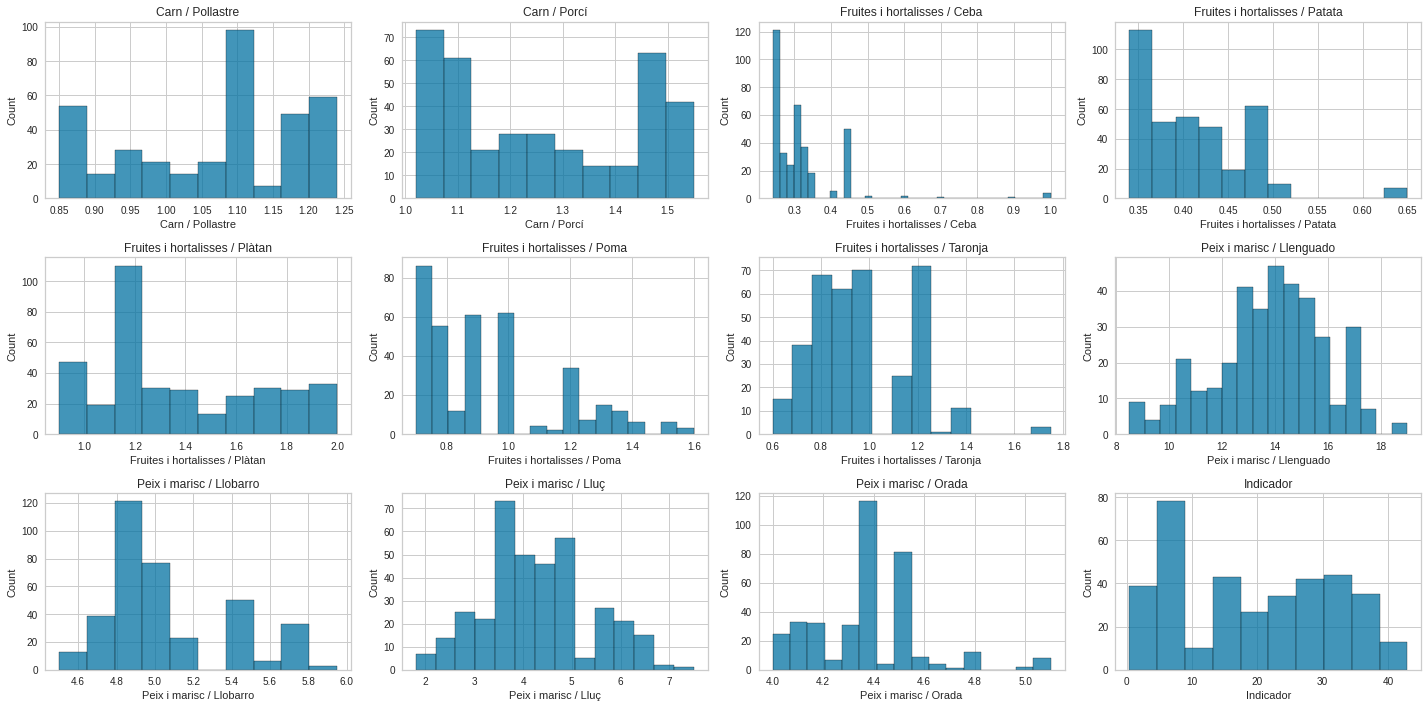

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(20,10))

for i, c in enumerate(cesta_data.columns):
  ax = axes.reshape(-1)[i]
  if cesta_data[c].dtype.kind == 'O':
    a = sns.countplot(x=c,data=cesta_data,ax=ax)
  else:
    b = sns.histplot(x=c,data=cesta_data,ax=ax)
  t = ax.set_title(c)
plt.tight_layout()

Fijándonos en las gráficas que se muestran, podemos ver que los alimentos que forman parte de pescados y mariscos, son más caros (con diferencia) del resto de alimentos. Por otro lado, tanto frutas y hortalizas como carnes, tienen un precio bastante a la par. Destacar que las cebollas y las patatas tienen el precio más bajo de todos los alimentos.

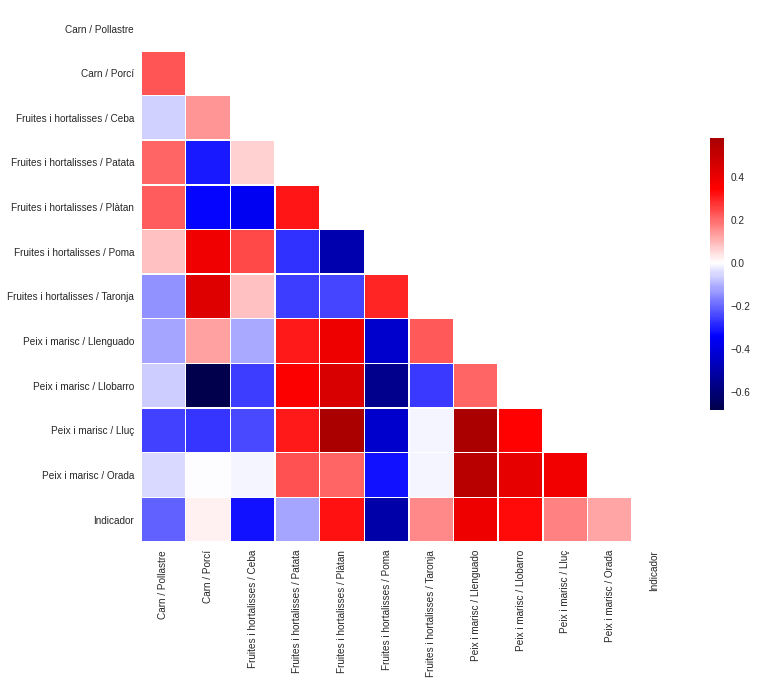

In [ ]:
corr = cesta_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.subplots(figsize=(12,10))
sns.heatmap(corr, mask=mask, cmap='seismic', center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5});

Vamos a fijarnos en la correlación que tienen los distintos alimentos con nuestra variable objetivo.

Podemos observar como todos los alimentos de la familia de *pescados y mariscos*, parecen tener una correlación positiva con la variable objetivo (especialemente el lenguado y la lubina). Respecto a frutas y hortalizas destacan la manzana y cebolla con una correlación negativa relativamente elevada. La correlación de la carne con la variable *Indicador* no parece ser muy elevada.

## División de los datos

Dividimos los datos en conjuntos de entrenamiento y test (80%/20%).

In [ ]:
from sklearn.model_selection import train_test_split

Xn = cesta_data.loc[:,cesta_data.columns != 'Indicador']
yn = cesta_data['Indicador']

X_train, X_test, y_train, y_test = train_test_split(Xn, yn, train_size=0.8, random_state=1)

## Preprocessing

Vamos a transformar las variables adecuadamente para poder ajustar modelos de regresión. Estandarizaremos tanto el conjunto de entrenamiento como el de test con el estimador *StandardScaler* proporcionado por la librería de scikir-learn.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(X_train)

# Transform the data
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

StandardScaler()

# Apartado b

Vamos a ajustar una SVM de regresión con kernel polinómico y con kernel RBF explorando los hiperparámetros adecuadamente. Elegiremos adecuadamente el modelo que parezca mejor y usaremos el método de *permutation_importance* sobre el test para determinar qué atributos son más importantes en el modelo para predecir.

In [ ]:
def save_results(clf, nclf, X, y, df):
    df.loc[nclf,'test_score'] = clf.score(X, y)
    df.loc[nclf,'cross_val_score'] = clf.best_score_
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

## Polynomial kernel

Para este kernel vamos a explorar los parámetros *C*, *gamma* y *degree* para ver con que valores de estos obtenemos mejores resultados.

In [ ]:
params = {'C': 10**np.linspace(-3,3,50),
          'gamma': 10**np.linspace(-9,3,50),
          'degree':[2,3]}

psvr =  SVR(kernel='poly', max_iter=25000, cache_size=2000)
psvr_gs =  GridSearchCV(psvr, params, cv=cv, n_jobs=-1)
psvr_gs.fit(X_train_s, y_train);

In [ ]:
show_html(pd.DataFrame(psvr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
389,"{'C': 0.002329951810515372, 'degree': 3, 'gamma': 3.556480306223121}",0.837789,1
2785,"{'C': 2.023589647725158, 'degree': 3, 'gamma': 0.3727593720314938}",0.837789,2
2186,"{'C': 0.3727593720314938, 'degree': 3, 'gamma': 0.6551285568595495}",0.837788,3
988,"{'C': 0.012648552168552958, 'degree': 3, 'gamma': 2.0235896477251556}",0.837788,4
4582,"{'C': 323.745754281764, 'degree': 3, 'gamma': 0.06866488450042998}",0.837788,5


Podemos ver como los resultados obtenidos son relativamente buenos, y es notable que apenas hay diferencia entre los primeros 5 resultados, el mejor de estos tiene un acierto de 0.8378, más o menos. El mejor de estos, lo hemos obtenido con un valor *C* de 0.002 aproximadamente, 3 como valor de *degree* y una *gamma* igual a, aproximadamente, 3.556.

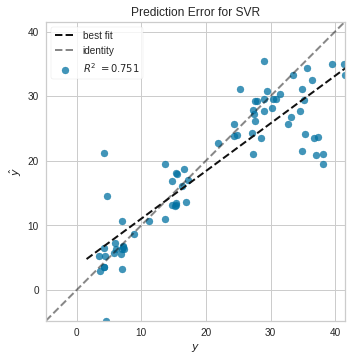

In [ ]:
psvr_gs_visualizer = prediction_error(psvr_gs.best_estimator_, X_train_s, y_train, X_test_s, y_test);

En este gráfico vemos la representación de las predicciones, teniendo en el eje x los valores reales de los individuos de *X_test* y en el eje y los valores asignados. Como podemos ver las muestras siguen a medias la teórica línea ideal y por eso quedan algo desviadas del comportamiento deseado, en otras palabras, nuestro acierto podría ser algo mejorable. El valor de $R^2$ es 0.751, este valor define, en palabras sencillas, que tan bien los datos se ajustan el modelo.

Vamos a ir guardando tanto el resultado de acierto en el test como el valor de $R^2$ para poder ir comparando los modelos que vayamos entrenando.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


,test_score,cross_val_score
Polynomial kernel,-2337.151373,0.837789


### RBF kernel

Para este kernel vamos a explorar los parámetros *C*, *gamma* y *epsilon* para ver con que valores de estos obtenemos mejores resultados.

In [ ]:
params = {'C':10**np.linspace(-3,3,50),
          'gamma':10**np.linspace(-9,3,50), 
          'epsilon':np.linspace(0,0.01,11)}

rbfsvr =  SVR(kernel='rbf', max_iter=25000, cache_size=2000)
rbfsvr_gs =  GridSearchCV(rbfsvr, params, cv=cv, n_jobs=-1)
rbfsvr_gs.fit(X_train_s, y_train);

In [ ]:
show_html(pd.DataFrame(rbfsvr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
24183,"{'C': 184.20699693267164, 'epsilon': 0.01, 'gamma': 0.12067926406393265}",0.905104,1
24133,"{'C': 184.20699693267164, 'epsilon': 0.009000000000000001, 'gamma': 0.12067926406393265}",0.905098,2
24083,"{'C': 184.20699693267164, 'epsilon': 0.008, 'gamma': 0.12067926406393265}",0.905093,3
24033,"{'C': 184.20699693267164, 'epsilon': 0.007, 'gamma': 0.12067926406393265}",0.905087,4
23983,"{'C': 184.20699693267164, 'epsilon': 0.006, 'gamma': 0.12067926406393265}",0.905080,5


Podemos ver como los resultados son bastante buenos, y es notable que apenas hay diferencia entre los primeros 5 resultados, el mejor de estos tiene un acierto de 0.905, más o menos. El mejor de estos lo hemos obtenido con un valor de *C* igual a 184.21 aproximadamente, cogiendo 0.01 por valor de *epsilon* y *gamma* igual a 0.12 aproximadamente.

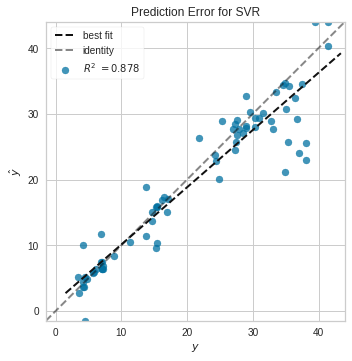

In [ ]:
rbfsvr_gs_visualizer = prediction_error(rbfsvr_gs.best_estimator_, X_train_s, y_train, X_test_s, y_test);

Como podemos ver sigue razonablemente bien la teórica línea ideal, y más aún si lo comparamos con el mejor modelo obtenido utilizando el kernel polinómico. El valor de $R^2$ es 0.878, este valor define, en palabras sencillas, que tan bien los datos se ajustan el modelo que en nuestro caso es un ajuste moderadamente bueno.

In [ ]:
results_df = save_results(rbfsvr_gs, 'RBF kernel', rbfsvr_gs.best_score_, rbfsvr_gs_visualizer, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,r2_score
RBF kernel,0.905104,0.877739
Polynomial kernel,0.837789,0.750540


Tal y como decíamos, este modelo presenta una clara mejora en acierto del conjunto test respecto al visto en la sección anterior. Sin ningún tipo de duda, este segundo modelo sería el escogido para utilizarlo en una aplicación real. Aún así, no deja de ser un acierto que aún tiene un algo de margen de mejora.

## Importancia de los parámetros en el mejor modelo

Vamos a ver ahora para el modelo que utiliza el kernel polinómico, ya que ha sido el que mejores resultados nos ha proporcionado, que importancia le da a cada uno de los parámetros a la hora de predecir un valor.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


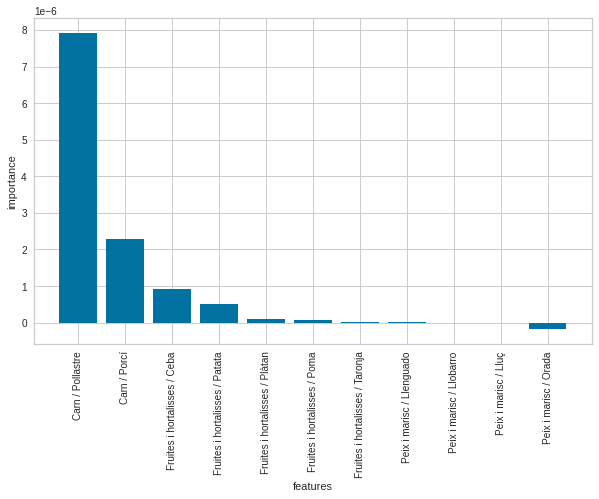

In [ ]:
result = permutation_importance(rbfsvr_gs, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

A simple vista, destaca claramente el pollo como parámetro decisivo a la hora de hacer predicciones. Algo por detrás, el cerdo y la cebolla, tienen una relevancia también importante, pero no tanto como la primera. Parece ser que sobretodo el pollo es el atributo más decisivo a la hora de tomar una decisión por parte del modelo. Respecto al resto de alimentos, a pesar de seguir aportando al modelo, ninguno destaca sobre el resto.

# Apartado c

Vamos a ajustar los modelos random forest y gradient boosting para regresión explorando los hiperparámetros adecuadamente. Elegiremos el mejor modelo entre los dos obtenido y utilizaramos el método permutation importance sobre el test para determinar qué atributos son más importantes en el modelo a la hora de predecir.

## Random forest

Para el modelo de random forest vamos a explorar los hiperparámetros *max_depth*, *max_features*, *min_samples_leaf* y *n_estimators* para ver con que valores obtenemos mejores resultados.

In [ ]:
params = {'max_depth': [None, 1, 2, 5, 10, 20, 30],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2, 3, 5, 10],
          'n_estimators': [5, 10, 25, 50, 75, 100, 200, 500, 1000, 2000]}

rf =  RandomForestRegressor(random_state=1)

rf_gs =  GridSearchCV(rf, params, cv=cv, n_jobs=-1)
rf_gs.fit(X_train, y_train);

In [ ]:
show_html(pd.DataFrame(rf_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
559,"{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 2000}",0.923671,1
659,"{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 2000}",0.923670,2
59,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 2000}",0.923670,2
558,"{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}",0.922563,4
58,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}",0.922563,5


Podemos ver como los resultados son muy buenos, y es notable que apenas hay diferencia entre los primeros 5 resultados, el mejor de estos tiene un acierto de 0.9237, más o menos. El mejor de estos lo hemos obtenido con *max_depth* con valor de 20, *sqrt* como valor de *max_features*, el *min_samples_leaf* a 1 y el valor de *n_estimators* igual a 2000.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


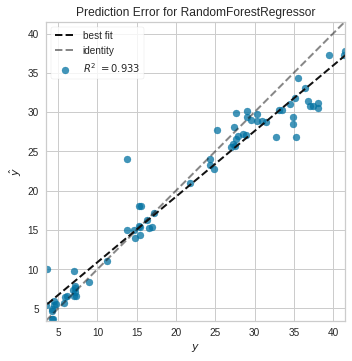

In [ ]:
rf_gs_visualizer = prediction_error(rf_gs.best_estimator_, X_train, y_train, X_test, y_test);

En este gráfico vemos la representación de las predicciones, teniendo en el eje x los valores reales de los individuos de *X_test* y en el eje y los valores asignados. Como podemos ver sigue bastante bien la teórica línea ideal, en otras palabras, nuestro acierto es alto. El valor de $R^2$ es 0.933, este valor define, en palabras sencillas, que tan bien los datos se ajustan el modelo.

In [ ]:
results_df = save_results(rf_gs, 'Random forest', rf_gs.best_score_, rf_gs_visualizer, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,r2_score
Random forest,0.923671,0.932678
RBF kernel,0.905104,0.877739
Polynomial kernel,0.837789,0.750540


Si comparamos además estos resultados con los obtenidos en el apartado anterior, podemos fijarnos en que los resultados han mejorado algo, sobretodo respecto al primer modelo que vimos. Entre el primer modelo entrenado y el modelo que acabamos de entrenar, podemos ver una mejora de casi 0.1 en el ratio de acierto del conjunto test. Podemos ver también como los valores $R^2$ han ido mejorando acorde a los resultados de los aciertos del test.

## Gradient boosting

Para el modelo de gradient boosting vamos a explorar los hiperparámetros *n_estimators*, *learning_rate*, *max_depth*, *subsample* y *loss* para ver con que valores obtenemos mejores resultados.

In [ ]:
params={'n_estimators':[10, 100, 250, 500, 1000],
        'learning_rate':[.001, 0.01, .1, 1],
        'max_depth':[1, 2, 5, 10],
        'subsample':[.5,.75,1],
        'loss':['squared_error', 'absolute_error']}

gbr = GradientBoostingRegressor(random_state=1)
gbr_gs = GridSearchCV(gbr, params)
gbr_gs.fit(X_train, y_train)

In [ ]:
show_html(pd.DataFrame(gbr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
162,"{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}",0.943369,1
342,"{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}",0.941333,2
339,"{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}",0.938647,3
238,"{'learning_rate': 0.01, 'loss': 'absolute_error', 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.75}",0.938620,4
163,"{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.75}",0.938443,5


Podemos ver como los resultados vuelven a ser bastante buenos, y es notable que no hay diferencia entre los primeros 5 resultados, el mejor de estos tiene un acierto de 0.943, más o menos. El mejor de estos lo hemos obtenido con *learning_rate* igual a 0.01, utilizando la función de perdida *squared_error*, *max_depth* con valor de 5, el número de estimadores igual a 1000 y la variable *subsample* igual a 0.5.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


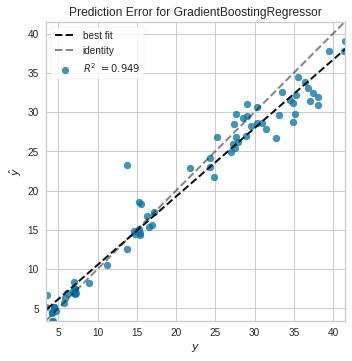

In [ ]:
gbr_gs_visualizer = prediction_error(gbr_gs.best_estimator_, X_train, y_train, X_test, y_test);

En este gráfico vemos la representación de las predicciones, teniendo en el eje x los valores reales de los individuos de *X_test* y en el eje y los valores asignados. Como podemos ver sigue bastante bien la teórica línea ideal, en otras palabras, nuestro acierto es alto. El valor de $R^2$ es 0.949 (algo mejor que el modelo con random forest), este valor define, en palabras sencillas, que tan bien los datos se ajustan el modelo.

In [ ]:
results_df = save_results(gbr_gs, 'Gradient boosting', gbr_gs.best_score_, gbr_gs_visualizer, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,r2_score
Gradient boosting,0.943369,0.949153
Random forest,0.923671,0.932678
RBF kernel,0.905104,0.877739
Polynomial kernel,0.837789,0.750540


Este modelo ha mejorado incluso aún más al modelo que habíamos entrenado utilizando random forest. Estos dos últimos modelos son mucho mejores que los entrenados en el apartado b, tal y como se ve claramente en los resultados de arriba. Si tuviéramos que elegir uno entre estos cuatro, nos quedaríamos con el modelo que utiliza gradient boosting por su gran porcentaje de acierto.

## Importancia de los parámetros en el mejor modelo

Vamos a ver ahora para el modelo que utiliza gradient boosting, ya que ha sido el que mejores resultados nos ha proporcionado, que importancia le da a cada uno de los parámetros a la hora de predecir un valor.

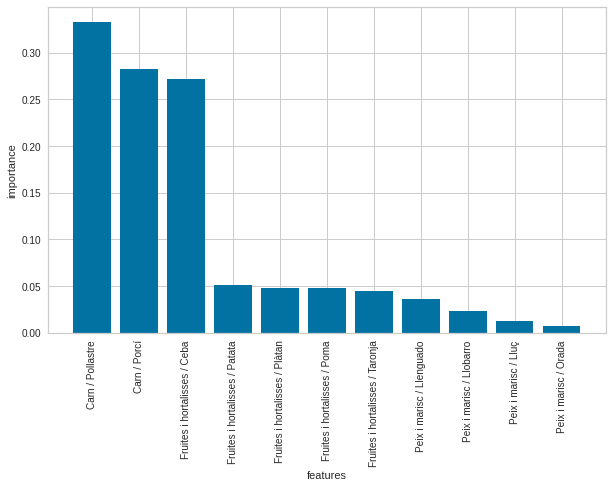

In [ ]:
result = permutation_importance(gbr_gs, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

Podemos ver como la carne sigue teniendo claramente una relevancia clave a la hora de predecir los valores, pero esta vez, tanto el pollo como el cerdo, han ganado gran importancia también. El resto de parámetros, parecen no ser muy relevantes, comparados a los tres mencionados, que son claramente los 3 que definirán la predicción de nuestro modelo.

# Apartado d

Como hemos visto en teoría cuando tenemos modelos diferentes podemos combinarlos
usando diferentes estrategias. Entrena un StackedRegressor y un VotingRegressor
usando los dos mejores modelos que has encontrado en los apartados anteriores con sus mejores hiperparámetros.

## StackedRegressor

Para este modelo, vamos a combinar el modelo entrenado con gradient boosting y el modelo entrenado con random forest.

In [ ]:
st_r = StackingRegressor([('rf', rf_gs.best_estimator_),
                          ('gbr', gbr_gs.best_estimator_)],
                          cv=cv, n_jobs=-1)
                             
st_r.fit(X_train, y_train);  

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


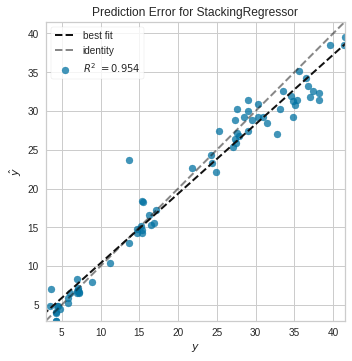

In [ ]:
str_visualizer = prediction_error(st_r, X_train, y_train, X_test, y_test);

En este gráfico vemos la representación de las predicciones, teniendo en el eje x los valores reales de los individuos de *X_test* y en el eje y los valores asignados. Como podemos ver sigue bastante bien la teórica línea ideal, en otras palabras, nuestro acierto es alto. El valor de $R^2$ es 0.954 (algo mejor que los mejores modelos vistos hasta ahora), este valor define, en palabras sencillas, que tan bien los datos se ajustan el modelo.

In [ ]:
results_df = save_results(st_r, 'Stacking regressor', st_r.score(X_test, y_test), str_visualizer, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,r2_score
Stacking regressor,0.954340,0.954340
Gradient boosting,0.943369,0.949153
Random forest,0.923671,0.932678
RBF kernel,0.905104,0.877739
Polynomial kernel,0.837789,0.750540


El modelo de stacking regressor, que combina el gradient boosting y el randon forest, ha obtenido el mejor de los resultados vistos hasta ahora. La mejora ha sido de 0.01 en el ratio de acierto del conjunto test, dado el cada vez más pequeño margen de mejora que tenemos, es una notable mejora.

## Importancia de los parámetros

Vamos a ver ahora para el modelo entrenado, que importancia le da a cada uno de los parámetros a la hora de predecir un valor.

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


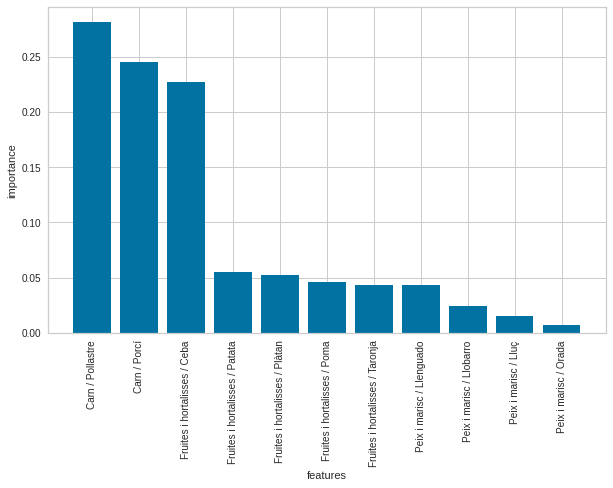

In [ ]:
result = permutation_importance(st_r, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

La importancia que se le da a las distintas variables no ha cambiado respecto a otros modelos. Los productos cárnicos y la cebolla siguen siendo claramente los que definirán en mayor medida las predicciones hechas por el modelo.

## VotingRegressor

Para este modelo, vamos a combinar el modelo entrenado con gradient boosting y el modelo entrenado con random forest.

In [ ]:
vt_r = VotingRegressor([('rf', rf_gs.best_estimator_), ('gbr', gbr_gs.best_estimator_)],
                       n_jobs=-1)
                             
vt_r.fit(X_train, y_train);  

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


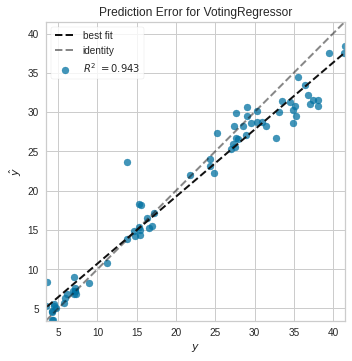

In [ ]:
vtr_visualizer = prediction_error(vt_r, X_train, y_train, X_test, y_test);

En este gráfico vemos la representación de las predicciones, teniendo en el eje x los valores reales de los individuos de *X_test* y en el eje y los valores asignados. Como podemos ver sigue bastante bien la teórica línea ideal, en otras palabras, nuestro acierto es alto. El valor de $R^2$ es 0.943 (algo mejor que los mejores modelos vistos hasta ahora pero no el mejor), este valor define, en palabras sencillas, que tan bien los datos se ajustan el modelo.

In [ ]:
results_df = save_results(vt_r, 'Voting regressor', vt_r.score(X_test, y_test), vtr_visualizer, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,r2_score
Stacking regressor,0.954340,0.954340
Gradient boosting,0.943369,0.949153
Voting regressor,0.942978,0.942978
Random forest,0.923671,0.932678
RBF kernel,0.905104,0.877739
Polynomial kernel,0.837789,0.750540


Tal y como veíamos, este modelo es bastante bueno pero no el mejor de los que hemos visto. El modelo de stacking regressor es el mejor modelo en cuanto a acierto del conjunto test con un acierto de más del 0.95, un muy buen modelo.

## Importancia de los parámetros

Vamos a ver ahora para el modelo entrenado, que importancia le da a cada uno de los parámetros a la hora de predecir un valor.

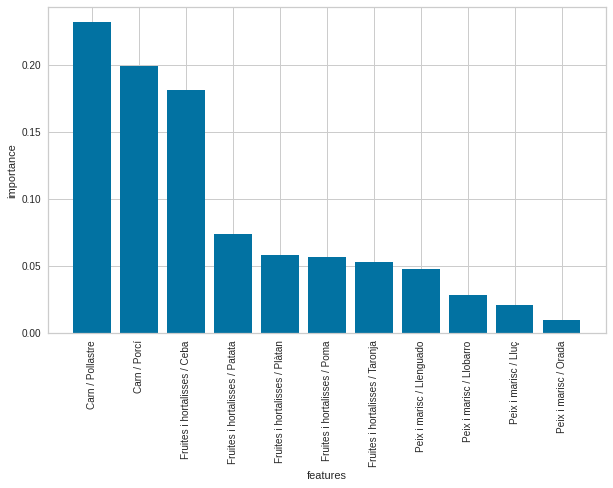

In [ ]:
result = permutation_importance(vt_r, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

La importancia que se le da a las distintas variables no ha cambiado respecto a otros modelos. Los productos cárnicos y la cebolla siguen siendo claramente los que definirán en mayor medida las predicciones hechas por el modelo.